In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
#import plotly.express as px
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [107]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_52404\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_52404\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_52404\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [108]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [109]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [110]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [111]:
data = data.dropna()

In [36]:
#energies = ['biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste',
#       'wind','total_aggregated', 'hydro_tot', 'gas_tot']

# 24h ARIMA

In [112]:
n_train = 35064
n_test = int(len(data)-n_train)

In [113]:
def arima_data_generator(data, feature):
    series = data['total_aggregated'].values
    train_array, test_array = series[:n_train], series[n_train:]
    # Replace NaN values with the mean of the series
    train_array[np.isnan(train_array)] = np.mean(train_array)
    test_array[np.isnan(test_array)] = np.mean(test_array)

        #train_df, test_df = pd.DataFrame(train_array), pd.DataFrame(test_array)

    return train_array, test_array

train, test = arima_data_generator(data, 'total_aggregated')


In [114]:
series = data['total_aggregated'].values
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
#scaler.fit(series[:n_train].reshape(-1,1))
## Transfom on both Training and Test data
#scaled_series = scaler.transform(series.reshape(-1, 1))

Test RMSE for AR(1): 6804.192


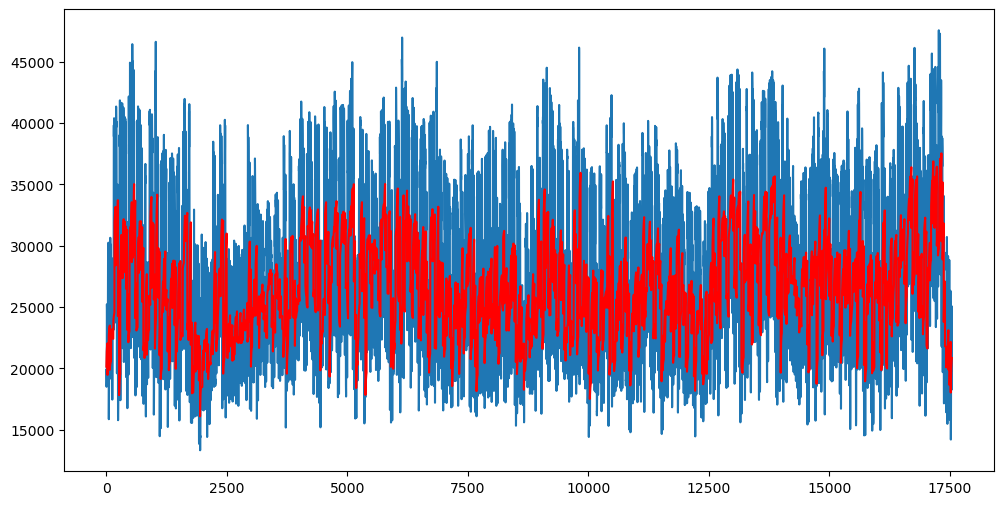

Test RMSE for AR(2): 6101.881


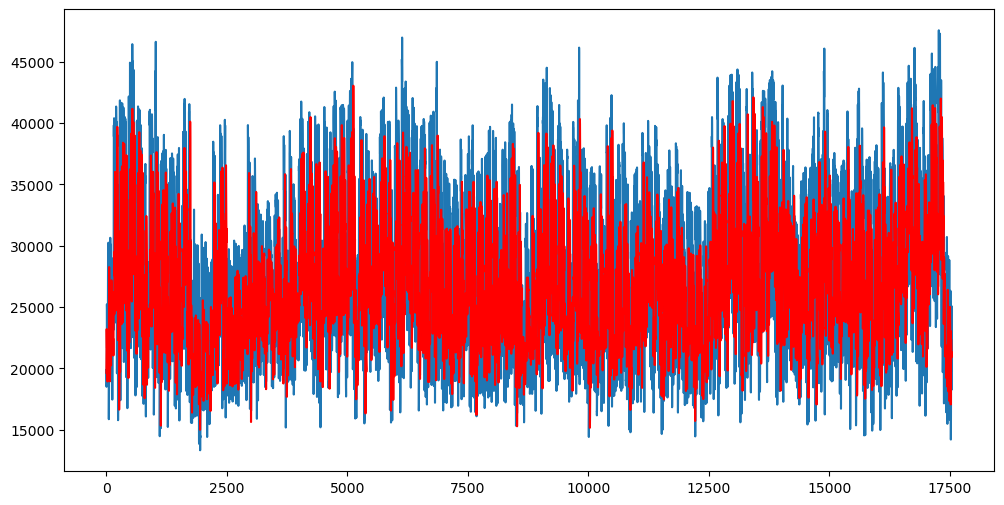

Test RMSE for AR(3): 6166.840


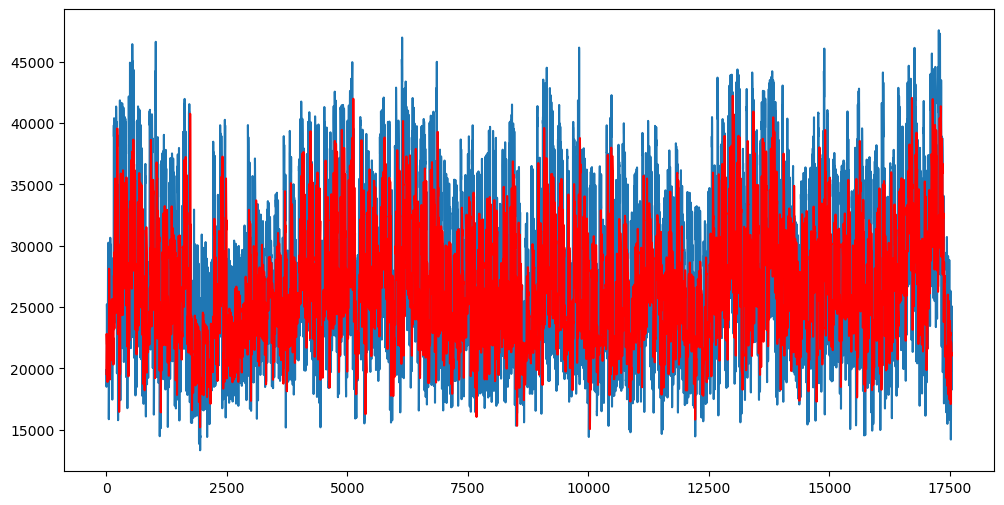

In [115]:
# train autoregression
ar_orders = [1,2,3]
for order in ar_orders:
    history = [x for x in train]
    predictions = list()
    window_size = 24
    for i in range(0, len(test), window_size):
        t_end = i + 24
        if t_end > len(test):
            t_end = len(test)
        test_block = test[i:t_end]
        model = ARIMA(history[-window_size:], order=(order,0,0))
        model_fit = model.fit()
        output = model_fit.forecast(steps=len(test_block))
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        history.extend(obs)
        #for z in zip(yhat, obs):
        #    print('predicted=%s, expected=%s' % z)
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE for AR({order}): %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

In [116]:

def sarimax_data_generator(data, feature, exog_features):
    series = data['total_aggregated'].values
    exog_data = data[exog_features].values
    train_array, test_array = series[:n_train], series[n_train:]
    train_exog, test_exog = exog_data[:n_train], exog_data[n_train:]
    # Replace NaN values with the mean of the train series
    train_array[np.isnan(train_array)] = np.mean(train_array)
    train_exog[np.isnan(train_exog)] = np.mean(train_exog)

    return train_array, test_array, train_exog, test_exog

train, test, train_exog, test_exog = sarimax_data_generator(data, 'total_aggregated', ['saturday', 'sunday'])

In [120]:
series = data['total_aggregated'].values
exog1 = data['saturday'].values
exog2 = data['sunday'].values

train_array, test_array = series[:n_train], series[n_train:]

target_scaler = MinMaxScaler()
train_scaled = target_scaler.fit_transform(train_array.reshape(-1,1))
test_scaled = target_scaler.transform(test_array.reshape(-1,1))

exog1_s = target_scaler.transform(exog1.reshape(-1,1))
exog2_s = target_scaler.transform(exog2.reshape(-1,1))

train_exog1, test_exog1 = exog1_s[:n_train], exog1_s[n_train:]
train_exog2, test_exog2 = exog2_s[:n_train], exog2_s[n_train:]

train_exog = np.concatenate((np.array(train_exog1).reshape(-1,1), np.array(train_exog2).reshape(-1,1)), axis = 1)
test_exog = np.concatenate((np.array(test_exog1).reshape(-1,1), np.array(test_exog2).reshape(-1,1)), axis = 1)

In [ ]:
#    return train_array, test_array, train_exog, test_exog
#train, test, train_exog, test_exog = sarimax_data_generator(data, 'total_aggregated', 'business hour')

Optimization terminated successfully.
         Current function value: -1.790684
         Iterations: 67
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -2.146760
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -1.823213
         Iterations: 85
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -2.018333
         Iterations: 72
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -1.682478
         Iterations: 90
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -2.029830
         Iterations: 63
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -1.964194
         Iterations: 89
         Function evaluations: 160
Optimization termina

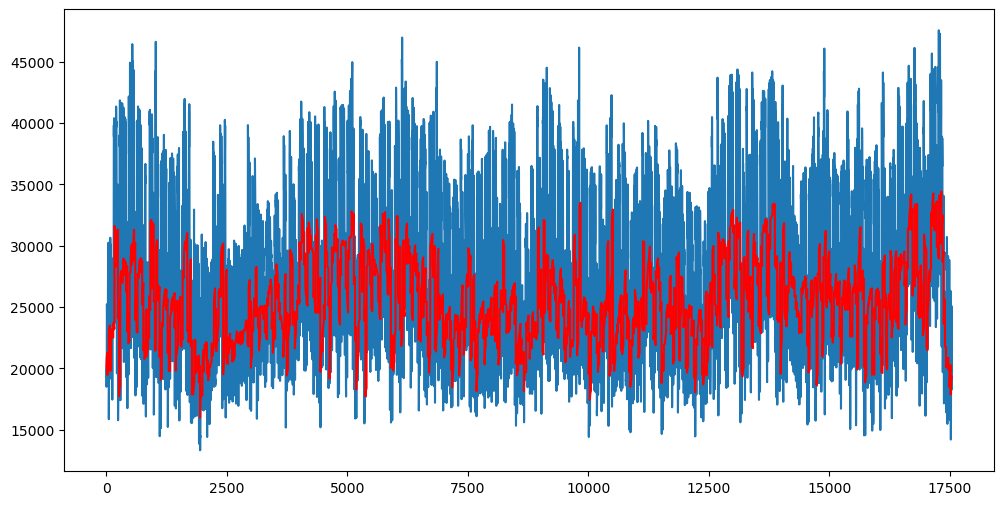

Optimization terminated successfully.
         Current function value: -2.228346
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -2.355816
         Iterations: 76
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.366556
         Iterations: 80
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -2.274163
         Iterations: 78
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -2.015475
         Iterations: 86
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -2.252416
         Iterations: 71
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -2.353470
         Iterations: 92
         Function evaluations: 163
Optimization termina

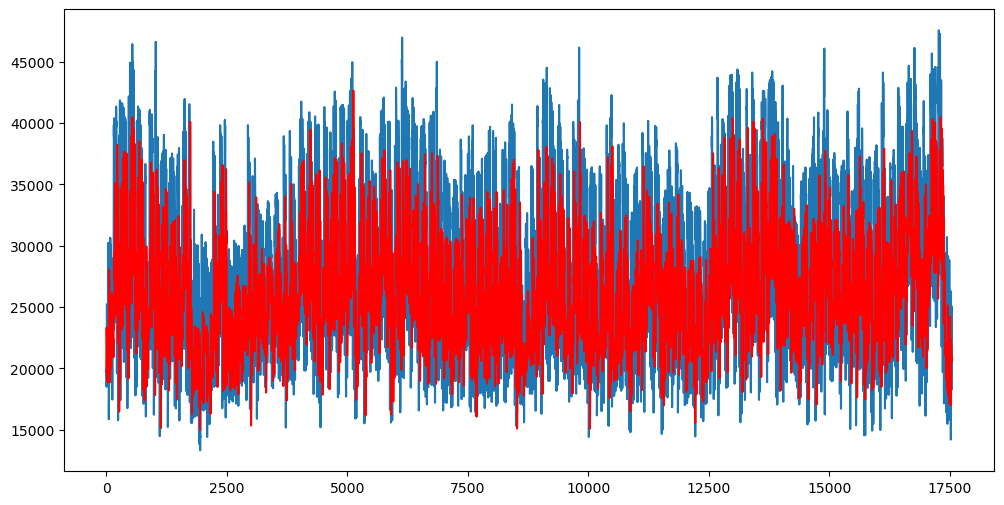

Optimization terminated successfully.
         Current function value: -2.252196
         Iterations: 86
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -2.365537
         Iterations: 142
         Function evaluations: 232


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\optimizer.py:728: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.277410
         Iterations: 152
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: -2.065442
         Iterations: 137
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -2.261986
         Iterations: 154
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -2.385339
         Iterations: 163
         Function evaluations: 272
Optimization terminated successfully.
         Current function value: -1.984477
         Iterations: 142
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -2.305615
         Iterations: 179
         Function evaluations: 294


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.894149
         Iterations: 122
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -2.318965
         Iterations: 163
         Function evaluations: 264


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.757600
         Iterations: 182
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: -1.760808
         Iterations: 109
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -2.024334
         Iterations: 125
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -2.012843
         Iterations: 103
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -1.913956
         Iterations: 116
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: -2.354061
         Iterations: 135
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: -2.374890
         Iterations: 148
         Function evaluations: 254
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.019421
         Iterations: 114
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -2.025806
         Iterations: 110
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: -2.072207
         Iterations: 97
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -2.023926
         Iterations: 160
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -2.147349
         Iterations: 171
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: -2.427161
         Iterations: 128
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: -1.955603
         Iterations: 180
         Function evaluations: 299
Optimization t

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.019737
         Iterations: 158
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -2.049196
         Iterations: 135
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: -1.440789
         Iterations: 140
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -1.909557
         Iterations: 113
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: -1.905979
         Iterations: 112
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -2.307943
         Iterations: 107
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -2.299925
         Iterations: 113
         Function evaluations: 193
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.375536
         Iterations: 98
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -1.921662
         Iterations: 149
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: -1.841891
         Iterations: 128
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -1.914770
         Iterations: 114
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -1.926099
         Iterations: 96
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -1.880246
         Iterations: 118
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: -2.097134
         Iterations: 136
         Function evaluations: 229
Optimization te

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.056202
         Iterations: 130
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -1.840286
         Iterations: 105
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -2.049490
         Iterations: 131
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -2.248515
         Iterations: 132
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -2.247248
         Iterations: 194
         Function evaluations: 318
Optimization terminated successfully.
         Current function value: -2.227512
         Iterations: 175
         Function evaluations: 293
Optimization terminated successfully.
         Current function value: -2.001393
         Iterations: 197
         Function evaluations: 323
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.785006
         Iterations: 165
         Function evaluations: 272
Optimization terminated successfully.
         Current function value: -1.947796
         Iterations: 148
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: -2.255410
         Iterations: 146
         Function evaluations: 242


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.374678
         Iterations: 126
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -2.240240
         Iterations: 118
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -2.332879
         Iterations: 159
         Function evaluations: 267


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.332767
         Iterations: 154
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -2.231911
         Iterations: 145
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -2.371718
         Iterations: 120
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: -2.589465
         Iterations: 180
         Function evaluations: 293
Optimization terminated successfully.
         Current function value: -2.211354
         Iterations: 93
         Function evaluations: 168


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.451177
         Iterations: 150
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: -2.369529
         Iterations: 148
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -2.217082
         Iterations: 170
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -2.330393
         Iterations: 169
         Function evaluations: 280
Optimization terminated successfully.
         Current function value: -2.379391
         Iterations: 123
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -2.230045
         Iterations: 129
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: -2.403815
         Iterations: 110
         Function evaluations: 189


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.863166
         Iterations: 174
         Function evaluations: 287
Optimization terminated successfully.
         Current function value: -1.849784
         Iterations: 130
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -1.904897
         Iterations: 170
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: -2.010304
         Iterations: 120
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -2.502456
         Iterations: 152
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -2.157376
         Iterations: 153
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -2.038129
         Iterations: 149
         Function evaluations: 247
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.472114
         Iterations: 117
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -2.346208
         Iterations: 174
         Function evaluations: 288
Optimization terminated successfully.
         Current function value: -2.204066
         Iterations: 104
         Function evaluations: 183


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.111647
         Iterations: 199
         Function evaluations: 318


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\s

Optimization terminated successfully.
         Current function value: -2.209599
         Iterations: 118
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -2.264941
         Iterations: 182
         Function evaluations: 298


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.347286
         Iterations: 153
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: -2.065078
         Iterations: 162
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: -2.055633
         Iterations: 149
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: -2.162081
         Iterations: 149
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: -1.884412
         Iterations: 105
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -2.166331
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -2.070951
         Iterations: 124
         Function evaluations: 216
Optimization t

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.171968
         Iterations: 190
         Function evaluations: 307
Optimization terminated successfully.
         Current function value: -2.020974
         Iterations: 140
         Function evaluations: 231


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.992725
         Iterations: 193
         Function evaluations: 316
Optimization terminated successfully.
         Current function value: -2.343858
         Iterations: 187
         Function evaluations: 304
Optimization terminated successfully.
         Current function value: -1.935828
         Iterations: 125
         Function evaluations: 215


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.023038
         Iterations: 173
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: -2.015159
         Iterations: 137
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -2.083411
         Iterations: 159
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -2.058399
         Iterations: 141
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -2.376042
         Iterations: 145
         Function evaluations: 233


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.080706
         Iterations: 126
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -2.073285
         Iterations: 190
         Function evaluations: 311
Optimization terminated successfully.
         Current function value: -2.057815
         Iterations: 130
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -2.110878
         Iterations: 163
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -2.200493
         Iterations: 128
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: -1.898193
         Iterations: 125
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -2.281487
         Iterations: 109
         Function evaluations: 187
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.105605
         Iterations: 168
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: -1.727446
         Iterations: 182
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: -2.271220
         Iterations: 184
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: -2.082649
         Iterations: 132
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -2.451735
         Iterations: 182
         Function evaluations: 300


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.366301
         Iterations: 169
         Function evaluations: 271
Optimization terminated successfully.
         Current function value: -2.376541
         Iterations: 153
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: -2.516943
         Iterations: 117
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: -2.276212
         Iterations: 197
         Function evaluations: 329
Optimization terminated successfully.
         Current function value: -2.172297
         Iterations: 180
         Function evaluations: 288


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.233313
         Iterations: 142
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -2.300397
         Iterations: 197
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: -2.265710
         Iterations: 104
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -2.001470
         Iterations: 173
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: -2.098548
         Iterations: 132
         Function evaluations: 224


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.878817
         Iterations: 113
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -2.031315
         Iterations: 199
         Function evaluations: 325
Optimization terminated successfully.
         Current function value: -2.250803
         Iterations: 151
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: -2.409399
         Iterations: 140
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -2.039429
         Iterations: 191
         Function evaluations: 316
Optimization terminated successfully.
         Current function value: -1.814058
         Iterations: 110
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -2.611830
         Iterations: 136
         Function evaluations: 226
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.865030
         Iterations: 177
         Function evaluations: 299
Optimization terminated successfully.
         Current function value: -1.764377
         Iterations: 191
         Function evaluations: 313
Optimization terminated successfully.
         Current function value: -2.058463
         Iterations: 148
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: -2.096974
         Iterations: 146
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -1.587485
         Iterations: 106
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -1.625494
         Iterations: 122
         Function evaluations: 204


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.873530
         Iterations: 199
         Function evaluations: 324
Optimization terminated successfully.
         Current function value: -1.870440
         Iterations: 128
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: -1.972815
         Iterations: 95
         Function evaluations: 169


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.352312
         Iterations: 159
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -2.328722
         Iterations: 157
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: -2.116000
         Iterations: 163
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: -2.234786
         Iterations: 136
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -2.386324
         Iterations: 133
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: -1.540972
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -2.114301
         Iterations: 101
         Function evaluations: 179
Optimization t

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.877320
         Iterations: 153
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: -1.885100
         Iterations: 143
         Function evaluations: 235
Optimization terminated successfully.
         Current function value: -2.019526
         Iterations: 132
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -2.048286
         Iterations: 102
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -1.762221
         Iterations: 120
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: -1.800526
         Iterations: 136
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -1.853509
         Iterations: 112
         Function evaluations: 192
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.600184
         Iterations: 168
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -2.041210
         Iterations: 193
         Function evaluations: 314
Optimization terminated successfully.
         Current function value: -2.298259
         Iterations: 101
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -1.904781
         Iterations: 105
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -1.861867
         Iterations: 166
         Function evaluations: 273
Optimization terminated successfully.
         Current function value: -1.805254
         Iterations: 147
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: -1.845093
         Iterations: 149
         Function evaluations: 252
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.105802
         Iterations: 105
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -1.716876
         Iterations: 181
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: -1.738923
         Iterations: 113
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -1.877233
         Iterations: 134
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -2.138659
         Iterations: 151
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: -1.967555
         Iterations: 126
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -2.208934
         Iterations: 143
         Function evaluations: 235
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.888002
         Iterations: 134
         Function evaluations: 231


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.932364
         Iterations: 138
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: -2.104998
         Iterations: 104
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -2.174233
         Iterations: 145
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -1.966199
         Iterations: 153
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -2.032196
         Iterations: 122
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -1.898605
         Iterations: 180
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: -1.952440
         Iterations: 141
         Function evaluations: 240
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.210129
         Iterations: 145
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -1.959410
         Iterations: 140
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -1.972941
         Iterations: 120
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -1.914504
         Iterations: 137
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -2.261201
         Iterations: 109
         Function evaluations: 183


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.874221
         Iterations: 123
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -2.094962
         Iterations: 89
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -2.085129
         Iterations: 132
         Function evaluations: 221


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.784173
         Iterations: 110
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -1.838264
         Iterations: 125
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -1.783472
         Iterations: 193
         Function evaluations: 311
Optimization terminated successfully.
         Current function value: -1.844204
         Iterations: 110
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -2.168232
         Iterations: 144
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -2.339993
         Iterations: 125
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: -1.785274
         Iterations: 146
         Function evaluations: 237
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.067105
         Iterations: 146
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -1.831722
         Iterations: 138
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -2.037533
         Iterations: 130
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -1.909482
         Iterations: 102
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -1.747814
         Iterations: 122
         Function evaluations: 210


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.721509
         Iterations: 131
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -1.581533
         Iterations: 146
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: -1.762299
         Iterations: 128
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -2.084561
         Iterations: 85
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -1.972680
         Iterations: 149
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -1.589021
         Iterations: 177
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -1.722589
         Iterations: 132
         Function evaluations: 225
Optimization t

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.173123
         Iterations: 165
         Function evaluations: 280
Optimization terminated successfully.
         Current function value: -1.958212
         Iterations: 94
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -1.719532
         Iterations: 133
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: -1.852789
         Iterations: 106
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -1.849161
         Iterations: 149
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -2.236550
         Iterations: 143
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -2.002292
         Iterations: 116
         Function evaluations: 195
Optimization t

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.887645
         Iterations: 109
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: -2.139739
         Iterations: 140
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -2.197349
         Iterations: 134
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -1.880328
         Iterations: 144
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -2.067957
         Iterations: 166
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: -1.963247
         Iterations: 125
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: -2.101379
         Iterations: 117
         Function evaluations: 199
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.899856
         Iterations: 94
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -2.097084
         Iterations: 132
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -2.415388
         Iterations: 134
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -2.207808
         Iterations: 134
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -1.993542
         Iterations: 129
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -1.973059
         Iterations: 92
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -2.049819
         Iterations: 141
         Function evaluations: 238
Optimization te

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.715673
         Iterations: 181
         Function evaluations: 295
Optimization terminated successfully.
         Current function value: -2.210388
         Iterations: 134
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: -1.904941
         Iterations: 122
         Function evaluations: 205


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.796817
         Iterations: 108
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -2.219951
         Iterations: 169
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: -1.808722
         Iterations: 190
         Function evaluations: 317
Optimization terminated successfully.
         Current function value: -2.549491
         Iterations: 196
         Function evaluations: 327
Optimization terminated successfully.
         Current function value: -2.241229
         Iterations: 114
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -1.751445
         Iterations: 123
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: -2.030501
         Iterations: 130
         Function evaluations: 217
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.920584
         Iterations: 107
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -1.908966
         Iterations: 198
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: -1.938205
         Iterations: 105
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: -2.311157
         Iterations: 116
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -2.089289
         Iterations: 158
         Function evaluations: 262
Optimization terminated successfully.
         Current function value: -1.714506
         Iterations: 144
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: -1.769612
         Iterations: 121
         Function evaluations: 203


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.093272
         Iterations: 135
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: -2.523051
         Iterations: 146
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: -1.595419
         Iterations: 104
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: -1.504036
         Iterations: 153
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: -2.329833
         Iterations: 161
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: -1.842857
         Iterations: 155
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -2.104437
         Iterations: 133
         Function evaluations: 227
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.796356
         Iterations: 176
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: -2.199375
         Iterations: 143
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -2.041467
         Iterations: 94
         Function evaluations: 170


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.237912
         Iterations: 132
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -1.880757
         Iterations: 127
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -1.803917
         Iterations: 171
         Function evaluations: 288
Optimization terminated successfully.
         Current function value: -1.788416
         Iterations: 170
         Function evaluations: 271
Optimization terminated successfully.
         Current function value: -2.039163
         Iterations: 109
         Function evaluations: 185


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.122632
         Iterations: 114
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -2.369941
         Iterations: 150
         Function evaluations: 245


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.401979
         Iterations: 195
         Function evaluations: 326
Optimization terminated successfully.
         Current function value: -2.186830
         Iterations: 183
         Function evaluations: 306
Optimization terminated successfully.
         Current function value: -2.087619
         Iterations: 118
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -2.384333
         Iterations: 134
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: -2.237843
         Iterations: 104
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: -2.012544
         Iterations: 133
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -2.077469
         Iterations: 146
         Function evaluations: 245
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.851874
         Iterations: 165
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: -1.867567
         Iterations: 101
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: -1.859597
         Iterations: 187
         Function evaluations: 308
Optimization terminated successfully.
         Current function value: -1.573960
         Iterations: 196
         Function evaluations: 331
Optimization terminated successfully.
         Current function value: -1.941303
         Iterations: 123
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -2.173359
         Iterations: 196
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: -2.013785
         Iterations: 133
         Function evaluations: 222
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.180925
         Iterations: 119
         Function evaluations: 196


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.621026
         Iterations: 130
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -1.751230
         Iterations: 134
         Function evaluations: 231


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.926828
         Iterations: 125
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: -2.093011
         Iterations: 154
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -2.191349
         Iterations: 127
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -1.911874
         Iterations: 153
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: -1.854555
         Iterations: 151
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: -1.912262
         Iterations: 103
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -1.988695
         Iterations: 125
         Function evaluations: 210
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.707673
         Iterations: 183
         Function evaluations: 301
Optimization terminated successfully.
         Current function value: -1.704814
         Iterations: 147
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -1.887115
         Iterations: 124
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -1.708255
         Iterations: 168
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: -2.182231
         Iterations: 166
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: -2.035616
         Iterations: 110
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: -1.803368
         Iterations: 136
         Function evaluations: 231
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.174841
         Iterations: 158
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -1.834233
         Iterations: 130
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -1.714160
         Iterations: 112
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: -1.530309
         Iterations: 118
         Function evaluations: 198


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.915003
         Iterations: 199
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: -2.388562
         Iterations: 139
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -2.324006
         Iterations: 123
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -1.952741
         Iterations: 112
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -1.777276
         Iterations: 142
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: -1.852062
         Iterations: 109
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -2.210277
         Iterations: 160
         Function evaluations: 263
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.244263
         Iterations: 155
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -1.832671
         Iterations: 169
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -1.862511
         Iterations: 173
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -2.261230
         Iterations: 114
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -2.241418
         Iterations: 130
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -2.244321
         Iterations: 199
         Function evaluations: 326
Optimization terminated successfully.
         Current function value: -1.626619
         Iterations: 182
         Function evaluations: 290
Optimization 

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.810204
         Iterations: 181
         Function evaluations: 295
Optimization terminated successfully.
         Current function value: -1.773325
         Iterations: 137
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -2.077580
         Iterations: 181
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -1.957800
         Iterations: 115
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -2.005345
         Iterations: 156
         Function evaluations: 256


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -1.858125
         Iterations: 123
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: -1.889481
         Iterations: 155
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: -1.785257
         Iterations: 129
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: -1.521266
         Iterations: 194
         Function evaluations: 315
Optimization terminated successfully.
         Current function value: -1.927890
         Iterations: 167
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: -2.371481
         Iterations: 116
         Function evaluations: 191


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.135233
         Iterations: 122
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: -1.991875
         Iterations: 163
         Function evaluations: 279
Optimization terminated successfully.
         Current function value: -1.848857
         Iterations: 135
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: -2.030894
         Iterations: 122
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: -2.149152
         Iterations: 173
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -1.993827
         Iterations: 185
         Function evaluations: 307
Optimization terminated successfully.
         Current function value: -1.866281
         Iterations: 141
         Function evaluations: 237
Optimization 

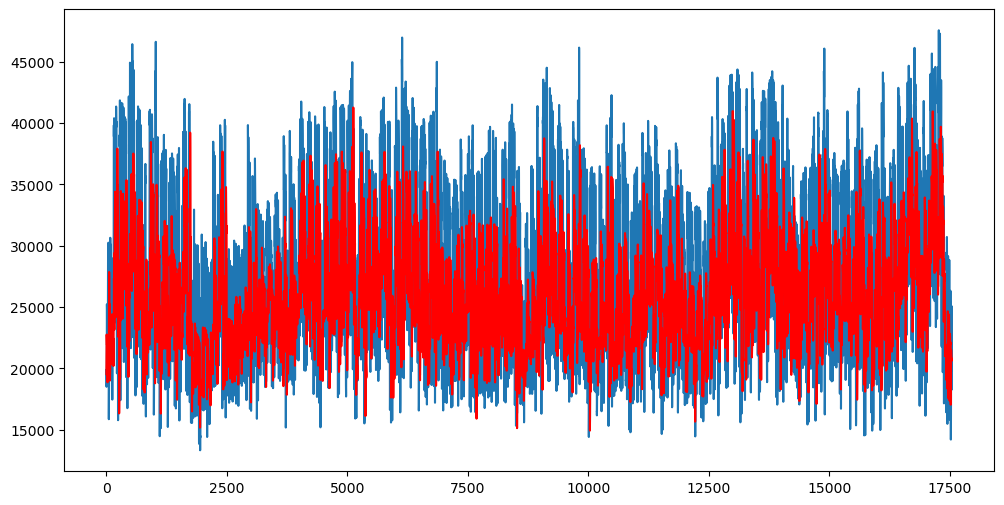

In [136]:
ar_orders = [1,2,3]
for order in ar_orders:
    history = [x for x in train_scaled]
    exog_history = [x for x in train_exog]
    predictions = list()
    window_size = 24
    for i in range(0, len(test_scaled), window_size):
        t_end = i + 24
        if t_end > len(test_scaled):
            t_end = len(test_scaled)
        test_block = test_scaled[i:t_end]
        exog_block = test_exog[i:t_end]
        model = SARIMAX(history[-window_size:], exog=exog_history[-window_size:], 
                        order=(order,0,0), seasonal_order=(0,0,0,24))
        model_fit = model.fit(method='nm',maxiter=200)
        output = model_fit.forecast(steps=len(test_block), exog=exog_block)
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        exog_obs = exog_block
        history.extend(obs)
        exog_history.extend(exog_obs)
        #for z in zip(yhat, obs):
        #    print('predicted=%s, expected=%s' % z)
    y_preds = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    #series = data['total_aggregated'].values
    truth = series[-len(test):]
    rmse = sqrt(mean_squared_error(truth, y_preds))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(y_preds, color='red')
    pyplot.show()

In [137]:
exog3 = data['business hour'].values

exog3_s = target_scaler.transform(exog3.reshape(-1,1))

train_exog3, test_exog3 = exog3_s[:n_train], exog3_s[n_train:]

Test RMSE: 6770.693


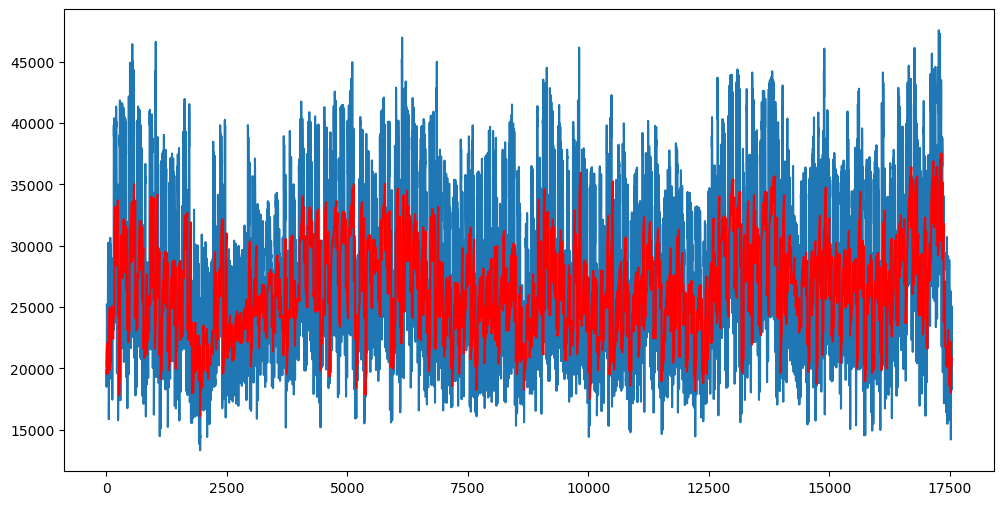

Test RMSE: 6101.496


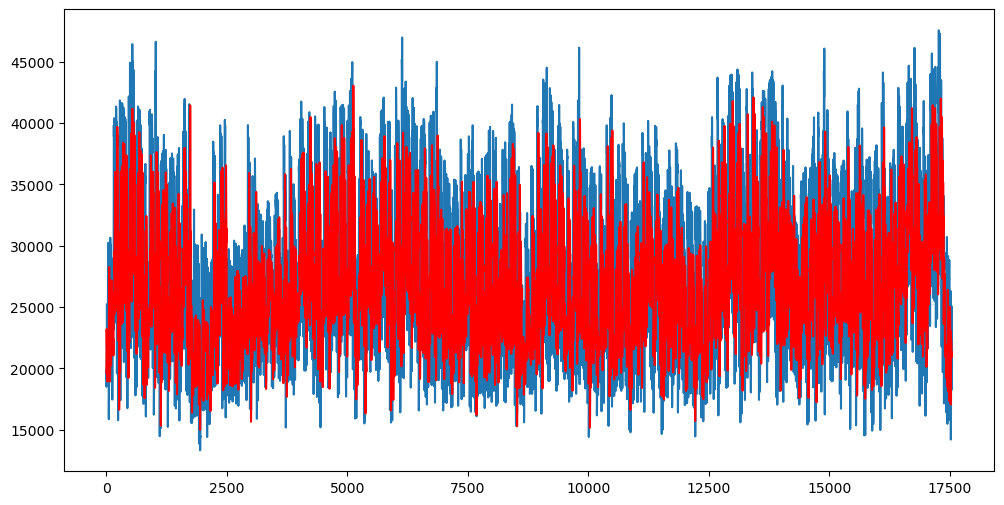

Test RMSE: 6166.784


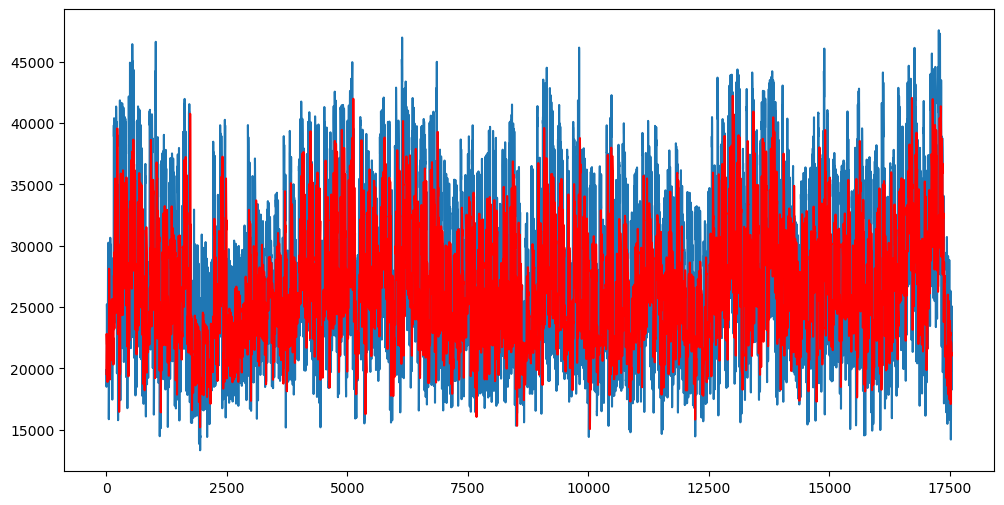

In [139]:
ar_orders = [1,2,3]
for order in ar_orders:
    history = [x for x in train]
    exog_history = [x for x in train_exog3]
    predictions = list()
    window_size = 24
    for i in range(0, len(test), window_size):
        t_end = i + 24
        if t_end > len(test):
            t_end = len(test)
        test_block = test[i:t_end]
        exog_block = test_exog3[i:t_end]
        model = SARIMAX(history[-window_size:], exog=exog_history[-window_size:], 
                        order=(order,0,0), seasonal_order=(0,0,0,24))
        model_fit = model.fit()
        output = model_fit.forecast(steps=len(test_block), exog=exog_block)
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        exog_obs = exog_block
        history.extend(obs)
        exog_history.extend(exog_obs)
        #for z in zip(yhat, obs):
        #    print('predicted=%s, expected=%s' % z)
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()